### GW tutorial 2: Detector noise and GW150914

Author: Melissa Lopez

Email: m.lopez@uu.nl

Note that we are importing some packages to be able to read the data.

In [4]:
!python3 --version
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd
import pylab
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import lal as _lal

Python 3.12.5


In the previous part we have seen the detector response to gravitational waves (GW). Currently, we have three ground-based detectors: LIGO Hanford (H1), LIGO Livingston (L1) and Virgo (V1). But what does the data actually look like?

To answer this question we are going to take a look at the first detection: **GW150914**. Let's load the data from L1

In [2]:
m = Merger('GW150914')
ifo = 'L1'
data = m.strain(ifo)

**Exercise 1:** We can see that this object is a PyCBC timeseries, and as such you can check what their atributes are (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#module-pycbc.types.timeseries)). Let's check some of them. 

- How much is the duration of the time series?

- How much is its sampling rate?

- How many data points does it have?

- How much is $\Delta_{f}$ and $\Delta_{t}$? Can you find a relation between these and the number of data points?

_Hint:_ $\Delta_{f} = 1/duration$ and  $\Delta_{t} = 1/sample\_rate$

In [3]:
# obtain total duration (seconds) of PyCBC timeseries 
# and print it out 
duration = data.duration
print(f"Duration of the time series: {duration} seconds")

# sampling rate (hertz) from timeseries
samplingrate = data.sample_rate
print(f"Sampling rate: {samplingrate} Hz")

# calculate number of datapoints in timeseries
num_datapoints = len(data)
print(f"Number of data points: {num_datapoints}")

# calculate frequency and time resolution from the above formulas
deltaf = 1/duration
print(f"Delta f: {deltaf}")
deltat = 1/samplingrate
print(f"Delta t: {deltat}")

# verify the relationship between the variables
relation = 1/(deltat*deltaf)
print(f"Relation confirmed: {relation}")

Duration of the time series: 32.0 seconds
Sampling rate: 4096.0 Hz
Number of data points: 131072
Delta f: 0.03125
Delta t: 0.000244140625
Relation confirmed: 131072.0


The previous magnitudes are key parameters of the timeseries. Now, let's plot the actual data to see what it looks like.

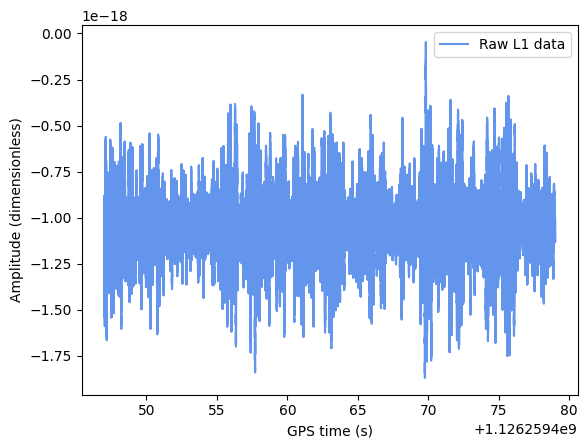

In [4]:
plt.plot(data.sample_times, data, label='Raw L1 data', color='cornflowerblue')
plt.xlabel('GPS time (s)')
plt.ylabel('Amplitude (dimensionless)')
plt.legend()

In GW we use the GPS time to determine at what time the GW signals reached Earth. You can see that the amplitude of this data is super small, $\mathcal{O}(10^{-18})$! GW interferometers are able to detect a change in distance of ~1/10,000th the size of a proton. 

But, where is GW190514? We cannot see it (yet) as there are many different contributions from the detector. The detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. 

**Exercise 2**: Estimate the PSD of the data using `filter_psd` (see [here](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.filter_psd)) and plot it. Limit your plot according to the minimum frequency (say, 1 Hz) and  the Nyquist frequency. 

_Hint_: Note that the PSD is a frequency series.

[6.83432239e-29 6.57364008e-29 5.87094751e-29 ... 2.74272339e-50
 4.34549770e-50 9.24349556e-50]


Text(0.5, 1.0, 'Power Spectral Density of GW150914 Data')

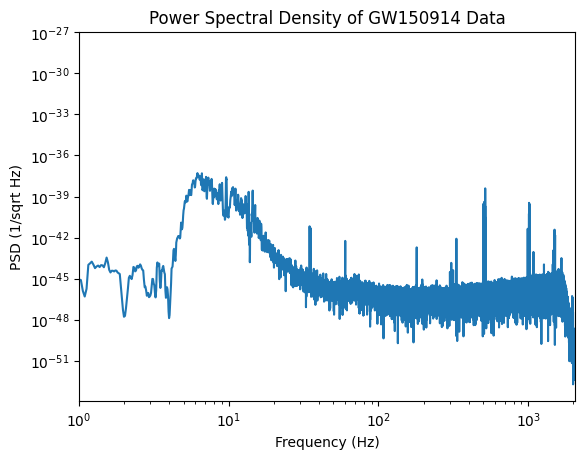

In [5]:
# lowest freq to consider in PSD plot 
flow = 1 

# nyquist frequency from halving the sampling rate 
# estimating power spectral density using input arguments of duration, frequency and flow
nyquistfreq = samplingrate/2
estimatedpsd = data.filter_psd(duration, deltaf, flow)
print(estimatedpsd)

# plotting psd using log scaling
plt.loglog(estimatedpsd.sample_frequencies, estimatedpsd, label="Estimated PSD")
plt.xlim(flow, nyquistfreq)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/sqrt Hz)")
plt.title("Power Spectral Density of GW150914 Data")

The PSD shows us what are the different contributions of the detector noise.
While we computed the PSD from 1 Hz, you can see that there is a weird behaviour for frequencies < 5 Hz. This is because the detector is not calibrated at these frequencies, so our analysis needs to start at higher frequencies. For current ground based detectors, we usually start at 10 Hz or higher, depending on the source.

GW signals are tiny, so with this much noise we won't be able to see GW150914. To "flatten" all frequency contributions we whiten the data.

**Exercise 3:** We can whiten the data with [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.whiten) function. Use `segment_duration = 4` and `max_filter_duration=4`. 

- Plot the whitened data next to the raw detector noise. What differences can you see?

- Estimate the PSD of the whitened data. Plot it in the same graph as the raw PSD. What differences can you see?


[1.24592506e+14 1.24167491e+14 1.22895639e+14 ... 1.85505327e+00
 2.83536273e+00 5.71316349e+00]


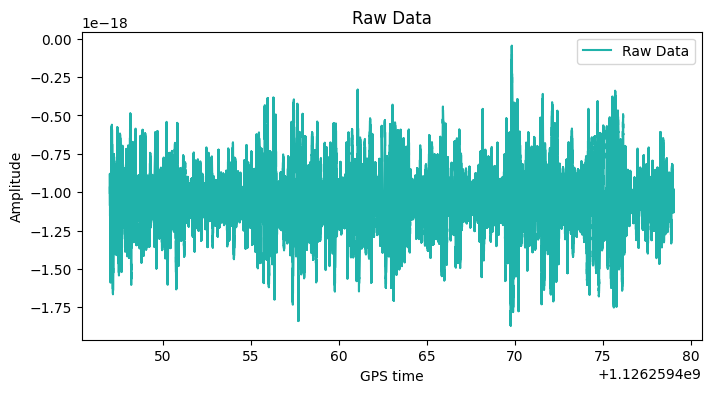

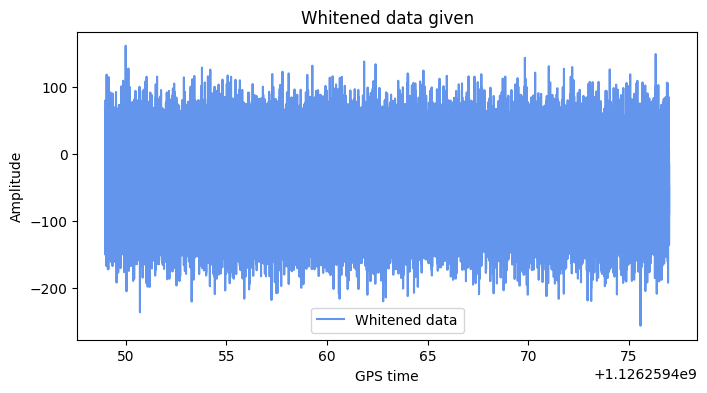

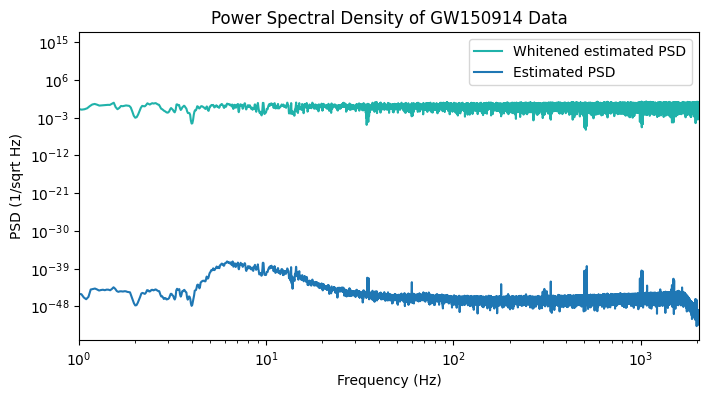

In [14]:
segment_duration = 4
max_filter_duration = 4

# whitening the data using specified segment and filter durations
# and estimate the psd of the data 
whitened_data=data.whiten(segment_duration, max_filter_duration)
white_estimatedpsd = whitened_data.filter_psd(whitened_data.duration, whitened_data.delta_f, flow)
print(white_estimatedpsd)

# plot raw data 
plt.figure(figsize=(8,4))
plt.plot(data.sample_times, data, label='Raw Data', color='lightseagreen')
plt.xlabel("GPS time")
plt.ylabel("Amplitude")
plt.title("Raw Data")
plt.legend()

# plotting whitened data
plt.figure(figsize=(8,4))
plt.plot(whitened_data.sample_times, whitened_data, label='Whitened data', color='cornflowerblue')
plt.xlabel("GPS time")
plt.ylabel("Amplitude")
plt.title("Whitened data given")
plt.legend()

# plotting psd whitened data, and overplot original psd to compare 
plt.figure(figsize=(8,4))
plt.loglog(white_estimatedpsd.sample_frequencies, white_estimatedpsd, label="Whitened estimated PSD", color='lightseagreen')
plt.xlim(flow, nyquistfreq)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/sqrt Hz)")
plt.title("Whitened Psd")
plt.loglog(estimatedpsd.sample_frequencies, estimatedpsd, label="Estimated PSD")
plt.xlim(flow, nyquistfreq)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/sqrt Hz)")
plt.title("Power Spectral Density of GW150914 Data")
plt.legend()

Now all frequency contributions are at the same level, as we can see from the PSD. However, GW150914 is still hidden in the data. 


**Exercise 4:** We can apply a [low pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.lowpass_fir) and a [high pass filter](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.highpass_fir) to limit the frequency of the data. The low pass filters above 250 Hz (order=512) and the high pass filters below 30 Hz (order=512).

- Estimate the PSD of the bandpassed data and plot it together with the raw PSD and the whitened PSD. What is the bandpass doing?

- Plot the bandpassed data [cropping](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.crop) 12s on the left and 13s on the right. What can you see? Compare this to the raw data. What frequencies dominate in each case?

Text(0.5, 1.0, 'Cropped Whitened Bandpassed Data')

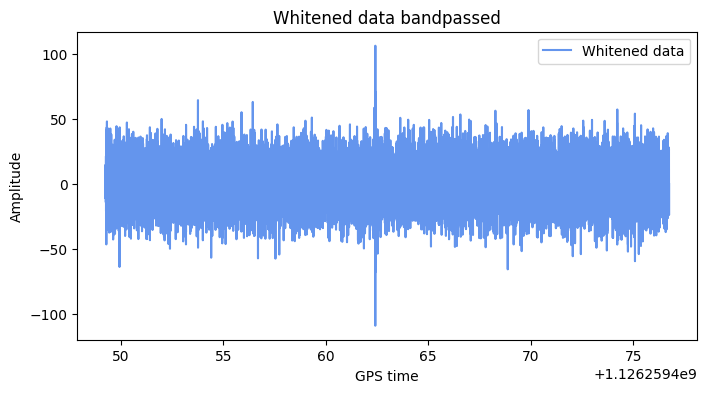

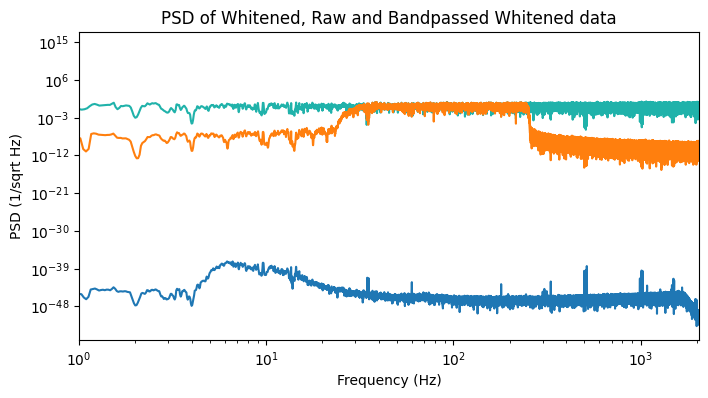

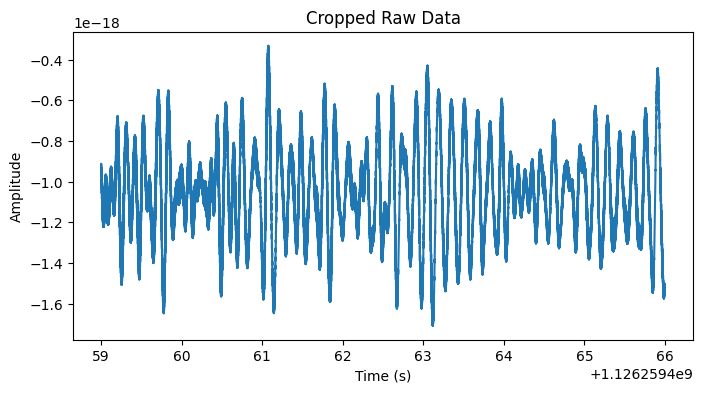

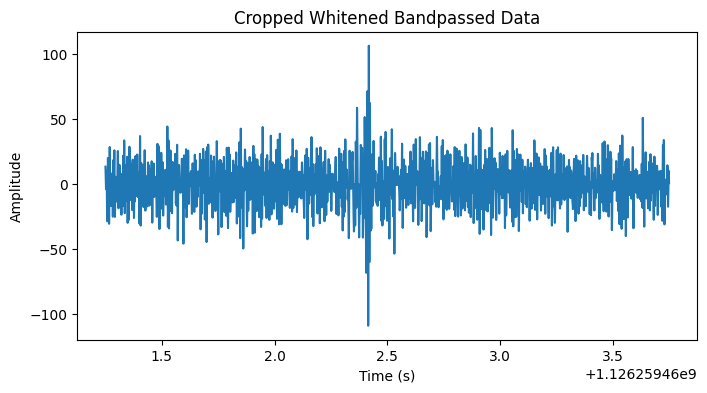

In [28]:
# defining high and low cutoff frequencies 
lowpass = 250 
highpass = 30
order = 512

# apply bandpass filter to the data 
# estimate the psd of the bandpassed data 
bandpassed_data = data.highpass_fir(highpass, order).lowpass_fir(lowpass, order)
psdbandpass = bandpassed_data.filter_psd(bandpassed_data.duration, bandpassed_data.delta_f, flow)
white_bandpassed_data = whitened_data.highpass_fir(highpass, order).lowpass_fir(lowpass, order)
white_psdbandpass = white_bandpassed_data.filter_psd(white_bandpassed_data.duration, white_bandpassed_data.delta_f, flow)

# plotting whitened and bandpassed data 
plt.figure(figsize=(8,4))
plt.plot(white_bandpassed_data.sample_times, white_bandpassed_data, label='Whitened data', color='cornflowerblue')
plt.xlabel("GPS time")
plt.ylabel("Amplitude")
plt.title("Whitened data bandpassed")
plt.legend()

# plotting psd of raw, whitened, and whitened bandpassed data 
plt.figure(figsize=(8,4))
plt.loglog(white_estimatedpsd.sample_frequencies, white_estimatedpsd, label="Estimated PSD", color='lightseagreen')
plt.xlim(flow, nyquistfreq)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/sqrt Hz)")
plt.title("Whitened Psd")
plt.loglog(estimatedpsd.sample_frequencies, estimatedpsd, label="Estimated PSD")
plt.xlim(flow, nyquistfreq)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/sqrt Hz)")
plt.title("Raw Psd")
plt.loglog(white_psdbandpass.sample_frequencies, white_psdbandpass, label="Estimated PSD")
plt.xlim(flow, nyquistfreq)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (1/sqrt Hz)")
plt.title("PSD of Whitened, Raw and Bandpassed Whitened data")

# croppping both left and right by given seconds 
crop_left = 12
crop_right = 13
cropped_data_bpsd = white_bandpassed_data.crop(crop_left, crop_right)
cropped_data = data.crop(crop_left, crop_right)

plt.figure(figsize=(8, 4))
plt.plot(cropped_data.sample_times, cropped_data, label="Cropped Bandpassed Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Cropped Raw Data")

plt.figure(figsize=(8, 4))
plt.plot(cropped_data_bpsd.sample_times, cropped_data_bpsd, label="Cropped Bandpassed Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Cropped Whitened Bandpassed Data")


**Exercise 5:** Last but not least, we generate a spectrogram (time-frequency representation) using [this](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.timeseries.TimeSeries.qtransform) function.

_Hint_: logfsteps=200, qrange=(110, 110), frange=(20, 512), vmax=3.5 as it is standard

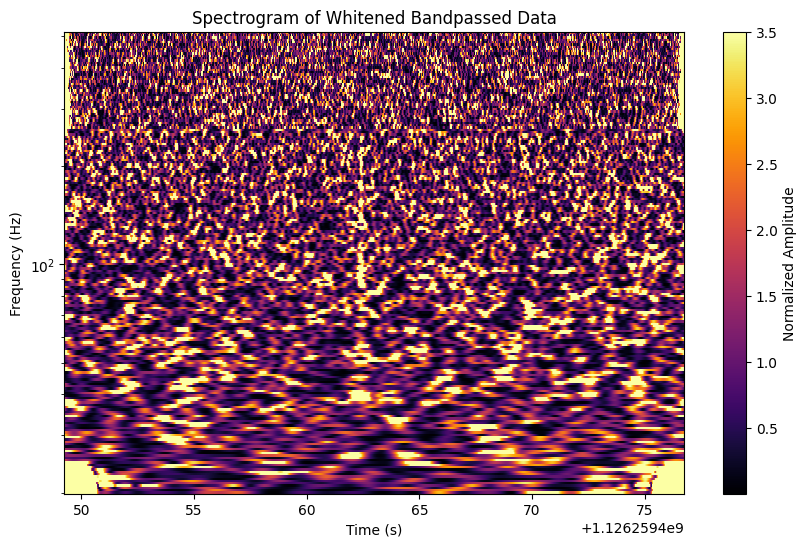

In [36]:
#PyCBC q-transform to generate spectogram of whitened and bandpassed data
times, frequencies, spectrogram = white_bandpassed_data.qtransform(delta_t=None, delta_f=None, 
    logfsteps=200, frange=(20, 512), qrange=(110, 110), mismatch=0.2, return_complex=False)
 
# plot the spectogram using pcolormesh
T, F = np.meshgrid(times, frequencies) 
plt.figure(figsize=(10, 6))
plt.pcolormesh(T, F, spectrogram, shading='auto', cmap='inferno', vmax=3.5)
plt.colorbar(label='Normalized Amplitude')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.yscale("log") 
plt.title("Spectrogram of Whitened Bandpassed Data")
plt.show()


As we have seen, the detector has a given "noise budget" given  by the power spectral density (PSD), $S_{n}(f)$, according to its specific design. Let's see how the detectors will improve in the next observing runs.

**Bonus track:** From the `sensitivity_curves` folder [load](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.read.from_txt) the PSD s:

- Third observing run of H1: `aligo_O3actual_H1.txt`
- Third observing run of L1: `aligo_O3actual_L1.txt`
- Third observing run of V1: `avirgo_O3actual.txt`
- Simulated fourth observing run of LIGO: `aligo_O4high.txt`

Note that these PSDs are from [LIGO public website](https://dcc.ligo.org/ligo-t2000012/public). Also read the PSD of [Einstein Telescope](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.EinsteinTelescopeP1600143) (ET) and [Cosmic Explorer](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.analytical.CosmicExplorerP1600143) (CE)

Plot all these PSDs. What can you say about ET and CE improvements?

_Hint_: Minimum frequency is 10 Hz, sampling rate 8192 Hz and duration is 16s.


Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.937500 Hz, available 5000.000000 Hz)


Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.937500 Hz, available 5000.000000 Hz)
Requested number of samples exceeds the highest available frequency in the input data, will use max available frequency instead. (requested 8191.937500 Hz, available 4995.378000 Hz)


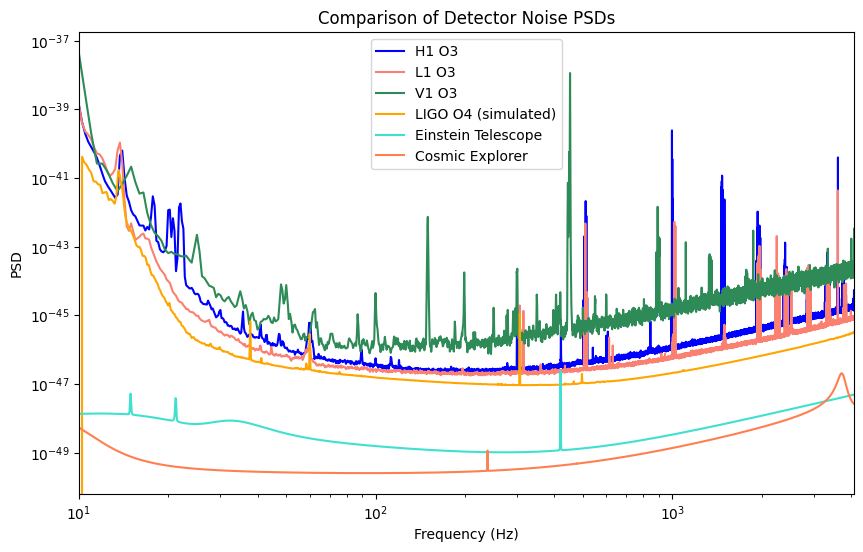

In [39]:
# defining the parameters
fmin = 10.0
delta_f = 1.0 / 16
sampling_rate = 8192
duration = 16
flength = int(sampling_rate * duration)

# loading psd from the given files 
psd_h1_o3 = pycbc.psd.read.from_txt("aligo_O3actual_H1.txt", flength, delta_f, fmin)
psd_l1_o3 = pycbc.psd.read.from_txt("aligo_O3actual_L1.txt", flength, delta_f, fmin)
psd_v1_o3 = pycbc.psd.read.from_txt("avirgo_O3actual.txt", flength, delta_f, fmin)
psd_ligo_o4 = pycbc.psd.read.from_txt("aligo_O4high.txt", flength, delta_f, 10.3)
# einstein and cosmic explorer psds
psd_et = pycbc.psd.analytical.EinsteinTelescopeP1600143(flen, delta_f, fmin) # <- Fixed line
psd_ce = pycbc.psd.analytical.CosmicExplorerP1600143(flen, delta_f, fmin) # <- Fixed line

# plot all of the above psds
plt.figure(figsize=(10, 6))
plt.loglog(psd_h1_o3.sample_frequencies, psd_h1_o3, label='H1 O3', color='blue')
plt.loglog(psd_l1_o3.sample_frequencies, psd_l1_o3, label='L1 O3', color='salmon')
plt.loglog(psd_v1_o3.sample_frequencies, psd_v1_o3, label='V1 O3', color='seagreen')
plt.loglog(psd_ligo_o4.sample_frequencies, psd_ligo_o4, label='LIGO O4 (simulated)', color='orange')
plt.loglog(psd_et.sample_frequencies, psd_et, label='Einstein Telescope', color='turquoise')
plt.loglog(psd_ce.sample_frequencies, psd_ce, label='Cosmic Explorer', color='coral')
plt.xlim(10, sampling_rate / 2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Comparison of Detector Noise PSDs')
plt.legend()
plt.show()

Good job! This is the end of the second part. Maybe you can go for a break?